100%|██████████| 55/55 [00:28<00:00,  1.96it/s]
<ipython-input-1-101a8b77d609>:64: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  Y_data = np.array(Y_data, dtype=np.bool)


X_data shape: (110, 256, 256, 3)
Y_data shape: (110, 256, 256, 1)
Epoch 1/25
6/6 [==============================] - 27s 1s/step - loss: 0.7106 - accuracy: 0.5128 - val_loss: 0.6164 - val_accuracy: 0.6811
Epoch 2/25
6/6 [==============================] - 1s 165ms/step - loss: 0.6661 - accuracy: 0.7606 - val_loss: 0.6136 - val_accuracy: 0.6818
Epoch 3/25
6/6 [==============================] - 1s 173ms/step - loss: 0.5424 - accuracy: 0.7635 - val_loss: 0.6147 - val_accuracy: 0.6818
Epoch 4/25
1/1 [==============================] - 1s 1s/step
Test Accuracy: 69.46896639737216%
F1-Score: 1.817347490470284e-05
Precision: 0.18181818181818182
1/1 [==============================] - 0s 24ms/step


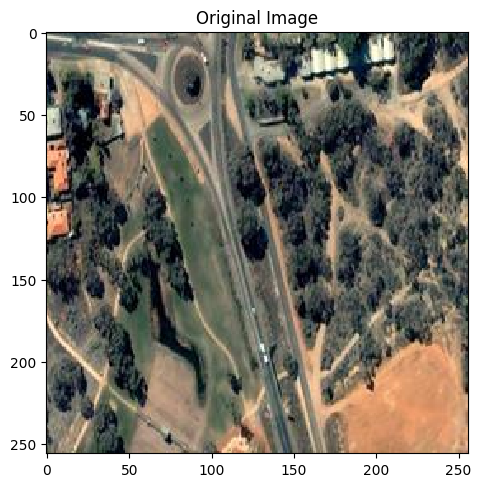

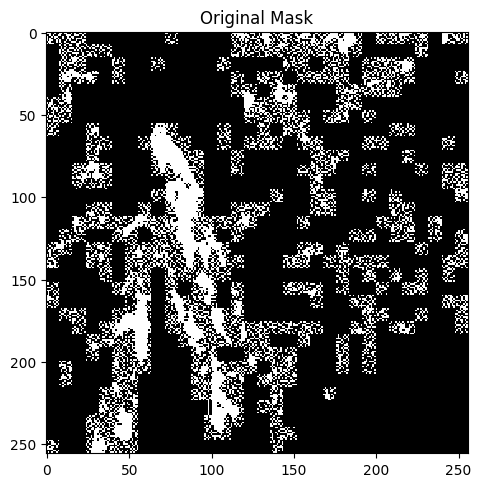

/usr/local/lib/python3.10/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


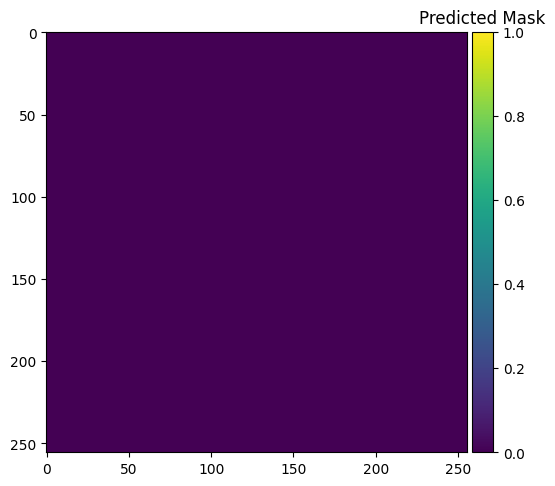

In [ ]:
import tensorflow as tf
import os
import numpy as np
from sklearn.model_selection import train_test_split

from tqdm import tqdm
from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt

seed = 42
np.random.seed = seed
import tensorflow as tf
import os
import numpy as np
from sklearn.model_selection import train_test_split

from tqdm import tqdm
from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt

seed = 42
np.random.seed = seed

IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3

# Update the path to your dataset root directory
ROOT_PATH = '/content/drive/MyDrive/Sowmik Dataset/Planned_way/'

# List of subfolder names containing images
image_subfolders = ['Forest all processed file/Preprocessed forest',
                    'Forest all processed file/PP aug_forests'
                    ]

# List of corresponding subfolders containing masks
mask_subfolders = ['Forest all processed file/Preprocessed forest/bmask_forest',
                   'Forest all processed file/PP aug_forests/abmask_forests'
                   ]

X_data = []
Y_data = []

for image_subfolder, mask_subfolder in zip(image_subfolders, mask_subfolders):
    IMAGE_PATH = os.path.join(ROOT_PATH, image_subfolder)
    MASK_PATH = os.path.join(ROOT_PATH, mask_subfolder)

    # Get a list of image file names from the current image subfolder
    image_files = [file for file in os.listdir(IMAGE_PATH) if file.endswith('.jpg')]  # Update the file extension if needed

    for n, image_file in tqdm(enumerate(image_files), total=len(image_files)):
        img = imread(os.path.join(IMAGE_PATH, image_file))[:, :, :IMG_CHANNELS]
        img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
        X_data.append(img)

        mask_file = f'pp_{image_file[:-4]}_mask.jpg'
        mask = imread(os.path.join(MASK_PATH, mask_file))
        mask = np.expand_dims(resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True), axis=-1)
        Y_data.append(mask)

X_data = np.array(X_data, dtype=np.uint8)
Y_data = np.array(Y_data, dtype=np.bool)

print('X_data shape:', X_data.shape)
print('Y_data shape:', Y_data.shape)
# Split the data into training and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(X_data, Y_data, test_size=0.1, random_state=seed)
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

#Contraction path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)

c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#Expansive path
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
#model.summary()
# Model checkpoint callback
checkpointer = tf.keras.callbacks.ModelCheckpoint('model_for_green_area.h5', verbose=1, save_best_only=True)
callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
        tf.keras.callbacks.TensorBoard(log_dir='logs')]
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=25, callbacks=callbacks)
# Import necessary libraries
from sklearn.metrics import accuracy_score, f1_score

# Assuming you have loaded and preprocessed your data and trained your model
# ...

# Predict on the validation data
prediction = model.predict(X_val)

# Threshold the predicted probabilities to get binary masks
prediction_binary = (prediction > 0.5).astype(np.uint8)
Y_val_binary = (Y_val > 0.5).astype(np.uint8)

# Calculate accuracy
accuracy = accuracy_score(Y_val_binary.flatten(), prediction_binary.flatten())

# Print the accuracy
print(f"Test Accuracy: {accuracy*100}%")

f1score = f1_score(Y_val_binary.flatten(), prediction_binary.flatten())

# Print the F1-score
print(f"F1-Score: {f1score}")

from sklearn.metrics import precision_score

# Calculate precision
precision = precision_score(Y_val_binary.flatten(), prediction_binary.flatten())

print(f"Precision: {precision}")
# Predict on the validation set
preds_val = model.predict(X_val, verbose=1)

# Threshold predictions (convert to binary)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

# Perform a sanity check on some random validation samples
ix = np.random.randint(0, len(X_val))
imshow(X_val[ix])
plt.title("Original Image")
plt.show()
imshow(np.squeeze(Y_val[ix]))
plt.title("Original Mask")
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.title("Predicted Mask")
plt.show()

100%|██████████| 183/183 [01:00<00:00,  3.05it/s]
<ipython-input-2-11a12124b924>:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  Y_data = np.array(Y_data, dtype=np.bool)


X_data shape: (367, 256, 256, 3)
Y_data shape: (367, 256, 256, 1)
Epoch 1/25
19/19 [==============================] - 13s 228ms/step - loss: 0.6244 - accuracy: 0.6728 - val_loss: 0.6000 - val_accuracy: 0.7049
Epoch 2/25
19/19 [==============================] - 3s 178ms/step - loss: 0.5742 - accuracy: 0.7181 - val_loss: 0.5697 - val_accuracy: 0.7049
Epoch 3/25
19/19 [==============================] - 4s 186ms/step - loss: 0.5459 - accuracy: 0.7182 - val_loss: 0.5353 - val_accuracy: 0.7050
Epoch 4/25
19/19 [==============================] - 3s 184ms/step - loss: 0.4825 - accuracy: 0.7551 - val_loss: 0.4372 - val_accuracy: 0.8164
Epoch 5/25
19/19 [==============================] - 3s 182ms/step - loss: 0.4411 - accuracy: 0.8096 - val_loss: 0.4394 - val_accuracy: 0.8002
Epoch 6/25
19/19 [==============================] - 3s 183ms/step - loss: 0.4142 - accuracy: 0.8236 - val_loss: 0.3869 - val_accuracy: 0.8389
Epoch 7/25
19/19 [==============================] - 4s 190ms/step - loss: 0.3861 

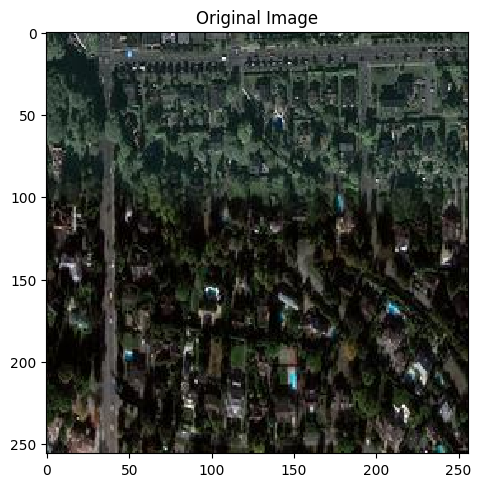

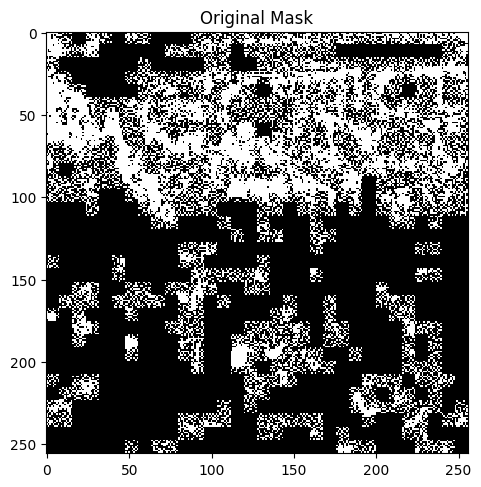

/usr/local/lib/python3.10/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


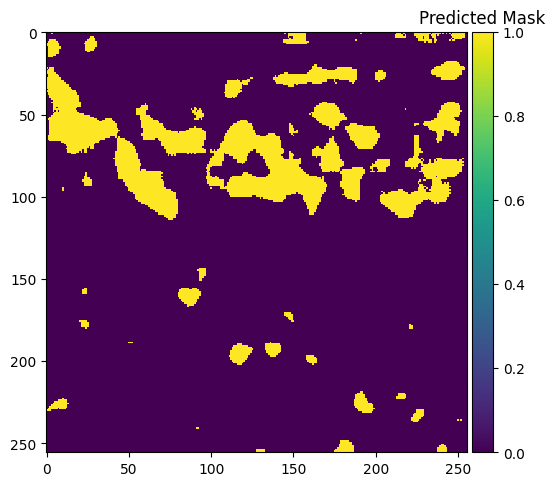

In [ ]:
import tensorflow as tf
import os
import numpy as np
from sklearn.model_selection import train_test_split

from tqdm import tqdm
from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt

seed = 42
np.random.seed = seed
import tensorflow as tf
import os
import numpy as np
from sklearn.model_selection import train_test_split

from tqdm import tqdm
from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt

seed = 42
np.random.seed = seed

IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3

# Update the path to your dataset root directory
ROOT_PATH = '/content/drive/MyDrive/Sowmik Dataset/Planned_way/'

# List of subfolder names containing images
image_subfolders = [
                    'Park all processed data/Preprocessed park',
                    'Park all processed data/PP aug_parks'
                    ]

# List of corresponding subfolders containing masks
mask_subfolders = [
                   'Park all processed data/Preprocessed park/bmask_park',
                   'Park all processed data/PP aug_parks/abmask_park'
                   ]

X_data = []
Y_data = []

for image_subfolder, mask_subfolder in zip(image_subfolders, mask_subfolders):
    IMAGE_PATH = os.path.join(ROOT_PATH, image_subfolder)
    MASK_PATH = os.path.join(ROOT_PATH, mask_subfolder)

    # Get a list of image file names from the current image subfolder
    image_files = [file for file in os.listdir(IMAGE_PATH) if file.endswith('.jpg')]  # Update the file extension if needed

    for n, image_file in tqdm(enumerate(image_files), total=len(image_files)):
        img = imread(os.path.join(IMAGE_PATH, image_file))[:, :, :IMG_CHANNELS]
        img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
        X_data.append(img)

        mask_file = f'pp_{image_file[:-4]}_mask.jpg'
        mask = imread(os.path.join(MASK_PATH, mask_file))
        mask = np.expand_dims(resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True), axis=-1)
        Y_data.append(mask)

X_data = np.array(X_data, dtype=np.uint8)
Y_data = np.array(Y_data, dtype=np.bool)

print('X_data shape:', X_data.shape)
print('Y_data shape:', Y_data.shape)
# Split the data into training and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(X_data, Y_data, test_size=0.1, random_state=seed)
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

#Contraction path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)

c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#Expansive path
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
#model.summary()
# Model checkpoint callback
checkpointer = tf.keras.callbacks.ModelCheckpoint('model_for_green_area.h5', verbose=1, save_best_only=True)
callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
        tf.keras.callbacks.TensorBoard(log_dir='logs')]
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=25, callbacks=callbacks)
# Import necessary libraries
from sklearn.metrics import accuracy_score, f1_score

# Assuming you have loaded and preprocessed your data and trained your model
# ...

# Predict on the validation data
prediction = model.predict(X_val)

# Threshold the predicted probabilities to get binary masks
prediction_binary = (prediction > 0.5).astype(np.uint8)
Y_val_binary = (Y_val > 0.5).astype(np.uint8)

# Calculate accuracy
accuracy = accuracy_score(Y_val_binary.flatten(), prediction_binary.flatten())

# Print the accuracy
print(f"Test Accuracy: {accuracy*100}%")

f1score = f1_score(Y_val_binary.flatten(), prediction_binary.flatten())

# Print the F1-score
print(f"F1-Score: {f1score}")

from sklearn.metrics import precision_score

# Calculate precision
precision = precision_score(Y_val_binary.flatten(), prediction_binary.flatten())

print(f"Precision: {precision}")
# Predict on the validation set
preds_val = model.predict(X_val, verbose=1)

# Threshold predictions (convert to binary)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

# Perform a sanity check on some random validation samples
ix = np.random.randint(0, len(X_val))
imshow(X_val[ix])
plt.title("Original Image")
plt.show()
imshow(np.squeeze(Y_val[ix]))
plt.title("Original Mask")
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.title("Predicted Mask")
plt.show()

100%|██████████| 260/260 [01:11<00:00,  3.61it/s]
<ipython-input-4-3ab333f87d4c>:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  Y_data = np.array(Y_data, dtype=np.bool)


X_data shape: (520, 256, 256, 3)
Y_data shape: (520, 256, 256, 1)
Epoch 1/25
27/27 [==============================] - 17s 321ms/step - loss: 0.5990 - accuracy: 0.7128 - val_loss: 0.5504 - val_accuracy: 0.7381
Epoch 2/25
27/27 [==============================] - 5s 186ms/step - loss: 0.5527 - accuracy: 0.7293 - val_loss: 0.5161 - val_accuracy: 0.7381
Epoch 3/25
27/27 [==============================] - 5s 188ms/step - loss: 0.5031 - accuracy: 0.7294 - val_loss: 0.4596 - val_accuracy: 0.7427
Epoch 4/25
27/27 [==============================] - 5s 188ms/step - loss: 0.4319 - accuracy: 0.7933 - val_loss: 0.4111 - val_accuracy: 0.8179
Epoch 5/25
27/27 [==============================] - 5s 186ms/step - loss: 0.3950 - accuracy: 0.8304 - val_loss: 0.3755 - val_accuracy: 0.8414
Epoch 6/25
27/27 [==============================] - 5s 183ms/step - loss: 0.3741 - accuracy: 0.8382 - val_loss: 0.3582 - val_accuracy: 0.8439
Epoch 7/25
27/27 [==============================] - 5s 185ms/step - loss: 0.3598 

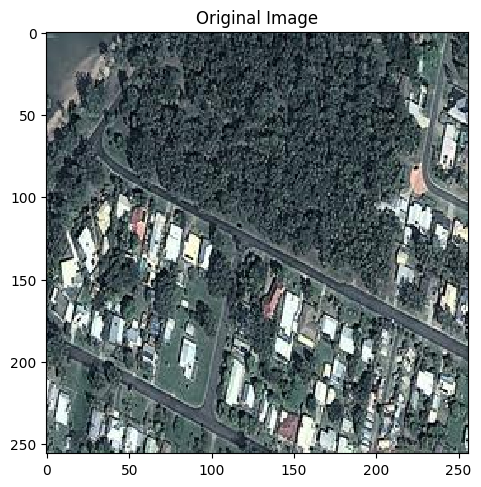

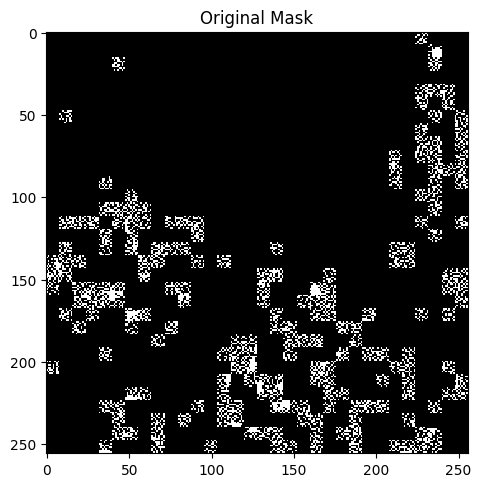

/usr/local/lib/python3.10/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


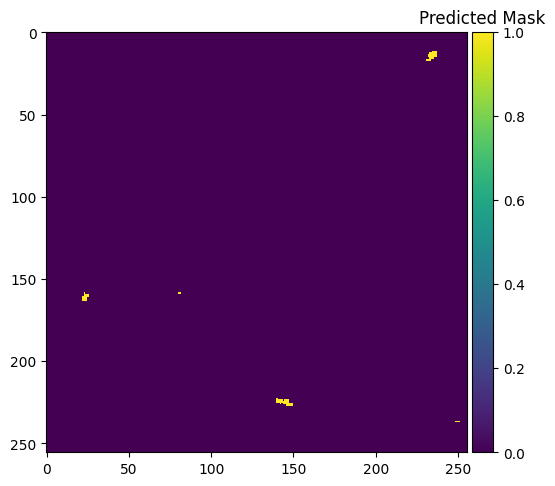

In [ ]:
import tensorflow as tf
import os
import numpy as np
from sklearn.model_selection import train_test_split

from tqdm import tqdm
from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt

seed = 42
np.random.seed = seed
import tensorflow as tf
import os
import numpy as np
from sklearn.model_selection import train_test_split

from tqdm import tqdm
from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt

seed = 42
np.random.seed = seed

IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3

# Update the path to your dataset root directory
ROOT_PATH = '/content/drive/MyDrive/Sowmik Dataset/Planned_way/'

# List of subfolder names containing images
image_subfolders = [
                    'Residence all processed data/Preprocessed Residence',
                    'Residence all processed data/PP aug_residence'
                    ]

# List of corresponding subfolders containing masks
mask_subfolders = [
                   'Residence all processed data/Preprocessed Residence/bmask_residence',
                   'Residence all processed data/PP aug_residence/abmask_residence'
                   ]

X_data = []
Y_data = []

for image_subfolder, mask_subfolder in zip(image_subfolders, mask_subfolders):
    IMAGE_PATH = os.path.join(ROOT_PATH, image_subfolder)
    MASK_PATH = os.path.join(ROOT_PATH, mask_subfolder)

    # Get a list of image file names from the current image subfolder
    image_files = [file for file in os.listdir(IMAGE_PATH) if file.endswith('.jpg')]  # Update the file extension if needed

    for n, image_file in tqdm(enumerate(image_files), total=len(image_files)):
        img = imread(os.path.join(IMAGE_PATH, image_file))[:, :, :IMG_CHANNELS]
        img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
        X_data.append(img)

        mask_file = f'pp_{image_file[:-4]}_mask.jpg'
        mask = imread(os.path.join(MASK_PATH, mask_file))
        mask = np.expand_dims(resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True), axis=-1)
        Y_data.append(mask)

X_data = np.array(X_data, dtype=np.uint8)
Y_data = np.array(Y_data, dtype=np.bool)

print('X_data shape:', X_data.shape)
print('Y_data shape:', Y_data.shape)
# Split the data into training and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(X_data, Y_data, test_size=0.1, random_state=seed)
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

#Contraction path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)

c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#Expansive path
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
#model.summary()
# Model checkpoint callback
checkpointer = tf.keras.callbacks.ModelCheckpoint('model_for_green_area.h5', verbose=1, save_best_only=True)
callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
        tf.keras.callbacks.TensorBoard(log_dir='logs')]
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=25, callbacks=callbacks)
# Import necessary libraries
from sklearn.metrics import accuracy_score, f1_score

# Assuming you have loaded and preprocessed your data and trained your model
# ...

# Predict on the validation data
prediction = model.predict(X_val)

# Threshold the predicted probabilities to get binary masks
prediction_binary = (prediction > 0.5).astype(np.uint8)
Y_val_binary = (Y_val > 0.5).astype(np.uint8)

# Calculate accuracy
accuracy = accuracy_score(Y_val_binary.flatten(), prediction_binary.flatten())

# Print the accuracy
print(f"Test Accuracy: {accuracy*100}%")

f1score = f1_score(Y_val_binary.flatten(), prediction_binary.flatten())

# Print the F1-score
print(f"F1-Score: {f1score}")

from sklearn.metrics import precision_score

# Calculate precision
precision = precision_score(Y_val_binary.flatten(), prediction_binary.flatten())

print(f"Precision: {precision}")
# Predict on the validation set
preds_val = model.predict(X_val, verbose=1)

# Threshold predictions (convert to binary)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

# Perform a sanity check on some random validation samples
ix = np.random.randint(0, len(X_val))
imshow(X_val[ix])
plt.title("Original Image")
plt.show()
imshow(np.squeeze(Y_val[ix]))
plt.title("Original Mask")
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.title("Predicted Mask")
plt.show()

**New Custom Dataset**

100%|██████████| 300/300 [03:56<00:00,  1.27it/s]
<ipython-input-2-1f43ebbac8ca>:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  Y_data = np.array(Y_data, dtype=np.bool)


X_data shape: (510, 256, 256, 3)
Y_data shape: (510, 256, 256, 1)
Epoch 1/25
26/26 [==============================] - 32s 367ms/step - loss: 0.5580 - accuracy: 0.7093 - val_loss: 0.4723 - val_accuracy: 0.7715
Epoch 2/25
26/26 [==============================] - 5s 181ms/step - loss: 0.4103 - accuracy: 0.8054 - val_loss: 0.3740 - val_accuracy: 0.7715
Epoch 3/25
26/26 [==============================] - 5s 182ms/step - loss: 0.3411 - accuracy: 0.8054 - val_loss: 0.2959 - val_accuracy: 0.7715
Epoch 4/25
26/26 [==============================] - 5s 182ms/step - loss: 0.3022 - accuracy: 0.8055 - val_loss: 0.2760 - val_accuracy: 0.7727
Epoch 5/25
26/26 [==============================] - 5s 183ms/step - loss: 0.2940 - accuracy: 0.8416 - val_loss: 0.2779 - val_accuracy: 0.8996
Epoch 6/25
26/26 [==============================] - 5s 186ms/step - loss: 0.2789 - accuracy: 0.8862 - val_loss: 0.2568 - val_accuracy: 0.9174
Epoch 7/25
26/26 [==============================] - 5s 185ms/step - loss: 0.2640 

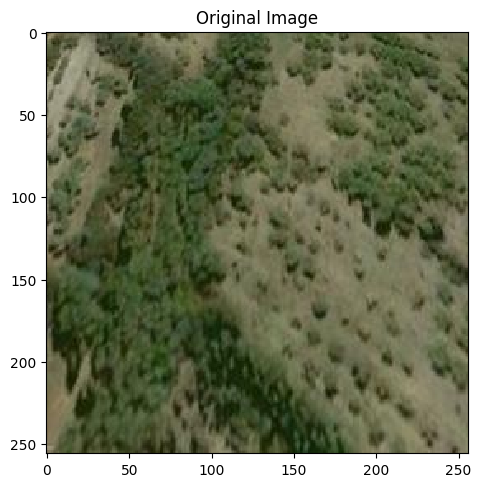

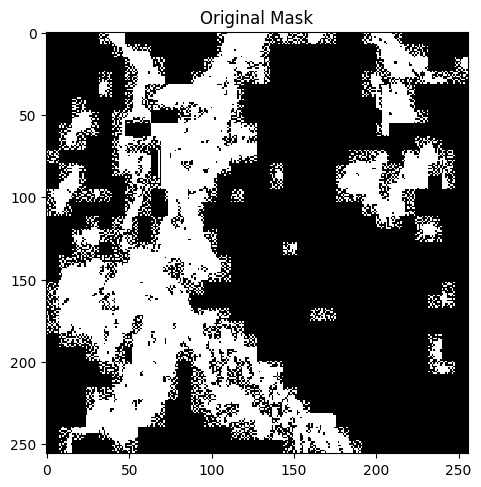

/usr/local/lib/python3.10/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


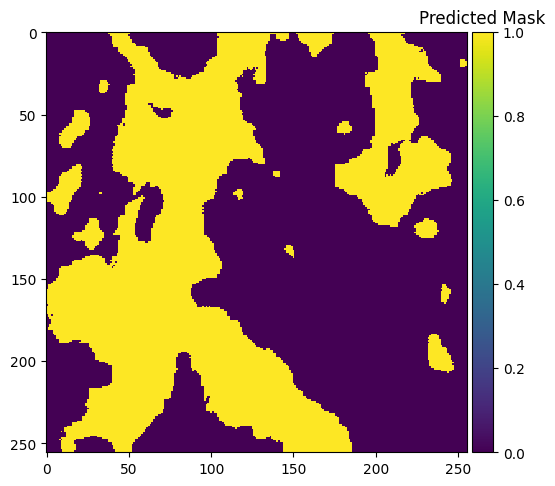

In [2]:
import tensorflow as tf
import os
import numpy as np
from sklearn.model_selection import train_test_split

from tqdm import tqdm
from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt

seed = 42
np.random.seed = seed
import tensorflow as tf
import os
import numpy as np
from sklearn.model_selection import train_test_split

from tqdm import tqdm
from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt

seed = 42
np.random.seed = seed

IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3

ROOT_PATH = '/content/drive/MyDrive/Sowmik Dataset/'

# List of subfolder names containing images
image_subfolders = ['Planned_way/Forest all processed file/Preprocessed forest',
                    'Planned_way/Forest all processed file/PP aug_forests',
                    'New dataset/Forest_all_processed_data',
                    'New dataset/Aug_all_processed_data/pp_aug_forest']

# List of corresponding subfolders containing masks
mask_subfolders = ['Planned_way/Forest all processed file/Preprocessed forest/bmask_forest',
                   'Planned_way/Forest all processed file/PP aug_forests/abmask_forests',
                   'New dataset/Forest_all_processed_data/bmask_forest',
                   'New dataset/Aug_all_processed_data/pp_aug_forest/pre_img_out/abmask_forest'
                   ]

X_data = []
Y_data = []

for image_subfolder, mask_subfolder in zip(image_subfolders, mask_subfolders):
    IMAGE_PATH = os.path.join(ROOT_PATH, image_subfolder)
    MASK_PATH = os.path.join(ROOT_PATH, mask_subfolder)

    # Get a list of image file names from the current image subfolder
    image_files = [file for file in os.listdir(IMAGE_PATH) if file.endswith('.jpg')]  # Update the file extension if needed

    for n, image_file in tqdm(enumerate(image_files), total=len(image_files)):
        img = imread(os.path.join(IMAGE_PATH, image_file))[:, :, :IMG_CHANNELS]
        img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
        X_data.append(img)

        mask_file = f'pp_{image_file[:-4]}_mask.jpg'
        mask = imread(os.path.join(MASK_PATH, mask_file))
        mask = np.expand_dims(resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True), axis=-1)
        Y_data.append(mask)

X_data = np.array(X_data, dtype=np.uint8)
Y_data = np.array(Y_data, dtype=np.bool)

print('X_data shape:', X_data.shape)
print('Y_data shape:', Y_data.shape)
# Split the data into training and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(X_data, Y_data, test_size=0.1, random_state=seed)
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

#Contraction path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)

c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#Expansive path
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
#model.summary()
# Model checkpoint callback
checkpointer = tf.keras.callbacks.ModelCheckpoint('model_for_green_area.h5', verbose=1, save_best_only=True)
callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
        tf.keras.callbacks.TensorBoard(log_dir='logs')]
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=25, callbacks=callbacks)
# Import necessary libraries
from sklearn.metrics import accuracy_score, f1_score

# Assuming you have loaded and preprocessed your data and trained your model
# ...

# Predict on the validation data
prediction = model.predict(X_val)

# Threshold the predicted probabilities to get binary masks
prediction_binary = (prediction > 0.5).astype(np.uint8)
Y_val_binary = (Y_val > 0.5).astype(np.uint8)

# Calculate accuracy
accuracy = accuracy_score(Y_val_binary.flatten(), prediction_binary.flatten())

# Print the accuracy
print(f"Test Accuracy: {accuracy*100}%")

f1score = f1_score(Y_val_binary.flatten(), prediction_binary.flatten())

# Print the F1-score
print(f"F1-Score: {f1score}")

from sklearn.metrics import precision_score

# Calculate precision
precision = precision_score(Y_val_binary.flatten(), prediction_binary.flatten())

print(f"Precision: {precision}")
# Predict on the validation set
preds_val = model.predict(X_val, verbose=1)

# Threshold predictions (convert to binary)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

# Perform a sanity check on some random validation samples
ix = np.random.randint(0, len(X_val))
imshow(X_val[ix])
plt.title("Original Image")
plt.show()
imshow(np.squeeze(Y_val[ix]))
plt.title("Original Mask")
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.title("Predicted Mask")
plt.show()

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


100%|██████████| 150/150 [01:58<00:00,  1.27it/s]
<ipython-input-3-9f81fcf35052>:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  Y_data = np.array(Y_data, dtype=np.bool)


X_data shape: (567, 256, 256, 3)
Y_data shape: (567, 256, 256, 1)
Epoch 1/25
29/29 [==============================] - 17s 373ms/step - loss: 0.5869 - accuracy: 0.7126 - val_loss: 0.5525 - val_accuracy: 0.7728
Epoch 2/25
29/29 [==============================] - 6s 192ms/step - loss: 0.5212 - accuracy: 0.7339 - val_loss: 0.3991 - val_accuracy: 0.8381
Epoch 3/25
29/29 [==============================] - 6s 195ms/step - loss: 0.4520 - accuracy: 0.8031 - val_loss: 0.3735 - val_accuracy: 0.8444
Epoch 4/25
29/29 [==============================] - 6s 211ms/step - loss: 0.4015 - accuracy: 0.8300 - val_loss: 0.3854 - val_accuracy: 0.8273
Epoch 5/25
29/29 [==============================] - 6s 193ms/step - loss: 0.3633 - accuracy: 0.8484 - val_loss: 0.3691 - val_accuracy: 0.8462
Epoch 6/25
29/29 [==============================] - 6s 193ms/step - loss: 0.3516 - accuracy: 0.8530 - val_loss: 0.3278 - val_accuracy: 0.8670
Epoch 7/25
29/29 [==============================] - 6s 194ms/step - loss: 0.3406 

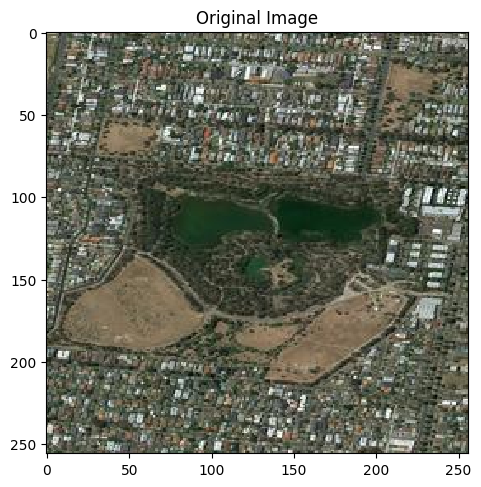

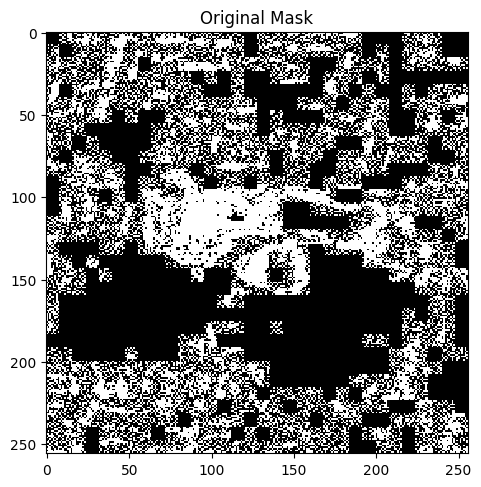

/usr/local/lib/python3.10/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


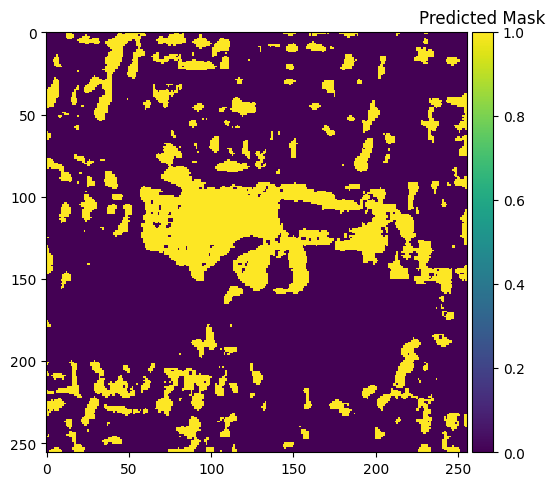

In [3]:
import tensorflow as tf
import os
import numpy as np
from sklearn.model_selection import train_test_split

from tqdm import tqdm
from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt

seed = 42
np.random.seed = seed
import tensorflow as tf
import os
import numpy as np
from sklearn.model_selection import train_test_split

from tqdm import tqdm
from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt

seed = 42
np.random.seed = seed

IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3

ROOT_PATH = '/content/drive/MyDrive/Sowmik Dataset/'

# List of subfolder names containing images
image_subfolders = ['Planned_way/Park all processed data/Preprocessed park',
                    'Planned_way/Park all processed data/PP aug_parks',
                    'New dataset/Park_all_processed_data',
                    'New dataset/Aug_all_processed_data/pp_aug_park']

# List of corresponding subfolders containing masks
mask_subfolders = ['Planned_way/Park all processed data/Preprocessed park/bmask_park',
                   'Planned_way/Park all processed data/PP aug_parks/abmask_park',
                   'New dataset/Park_all_processed_data/bmask_park',
                   'New dataset/Aug_all_processed_data/pp_aug_park/abmask_park'
                   ]

X_data = []
Y_data = []

for image_subfolder, mask_subfolder in zip(image_subfolders, mask_subfolders):
    IMAGE_PATH = os.path.join(ROOT_PATH, image_subfolder)
    MASK_PATH = os.path.join(ROOT_PATH, mask_subfolder)

    # Get a list of image file names from the current image subfolder
    image_files = [file for file in os.listdir(IMAGE_PATH) if file.endswith('.jpg')]  # Update the file extension if needed

    for n, image_file in tqdm(enumerate(image_files), total=len(image_files)):
        img = imread(os.path.join(IMAGE_PATH, image_file))[:, :, :IMG_CHANNELS]
        img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
        X_data.append(img)

        mask_file = f'pp_{image_file[:-4]}_mask.jpg'
        mask = imread(os.path.join(MASK_PATH, mask_file))
        mask = np.expand_dims(resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True), axis=-1)
        Y_data.append(mask)

X_data = np.array(X_data, dtype=np.uint8)
Y_data = np.array(Y_data, dtype=np.bool)

print('X_data shape:', X_data.shape)
print('Y_data shape:', Y_data.shape)
# Split the data into training and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(X_data, Y_data, test_size=0.1, random_state=seed)
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

#Contraction path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)

c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#Expansive path
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
#model.summary()
# Model checkpoint callback
checkpointer = tf.keras.callbacks.ModelCheckpoint('model_for_green_area.h5', verbose=1, save_best_only=True)
callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
        tf.keras.callbacks.TensorBoard(log_dir='logs')]
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=25, callbacks=callbacks)
# Import necessary libraries
from sklearn.metrics import accuracy_score, f1_score

# Assuming you have loaded and preprocessed your data and trained your model
# ...

# Predict on the validation data
prediction = model.predict(X_val)

# Threshold the predicted probabilities to get binary masks
prediction_binary = (prediction > 0.5).astype(np.uint8)
Y_val_binary = (Y_val > 0.5).astype(np.uint8)

# Calculate accuracy
accuracy = accuracy_score(Y_val_binary.flatten(), prediction_binary.flatten())

# Print the accuracy
print(f"Test Accuracy: {accuracy*100}%")

f1score = f1_score(Y_val_binary.flatten(), prediction_binary.flatten())

# Print the F1-score
print(f"F1-Score: {f1score}")

from sklearn.metrics import precision_score

# Calculate precision
precision = precision_score(Y_val_binary.flatten(), prediction_binary.flatten())

print(f"Precision: {precision}")
# Predict on the validation set
preds_val = model.predict(X_val, verbose=1)

# Threshold predictions (convert to binary)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

# Perform a sanity check on some random validation samples
ix = np.random.randint(0, len(X_val))
imshow(X_val[ix])
plt.title("Original Image")
plt.show()
imshow(np.squeeze(Y_val[ix]))
plt.title("Original Mask")
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.title("Predicted Mask")
plt.show()

100%|██████████| 105/105 [01:24<00:00,  1.25it/s]
<ipython-input-4-845281231309>:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  Y_data = np.array(Y_data, dtype=np.bool)


X_data shape: (660, 256, 256, 3)
Y_data shape: (660, 256, 256, 1)
Epoch 1/25
34/34 [==============================] - 18s 302ms/step - loss: 0.6142 - accuracy: 0.7478 - val_loss: 0.5490 - val_accuracy: 0.7277
Epoch 2/25
34/34 [==============================] - 7s 192ms/step - loss: 0.5211 - accuracy: 0.7613 - val_loss: 0.5371 - val_accuracy: 0.7277
Epoch 3/25
34/34 [==============================] - 6s 191ms/step - loss: 0.4961 - accuracy: 0.7613 - val_loss: 0.4970 - val_accuracy: 0.7277
Epoch 4/25
34/34 [==============================] - 7s 193ms/step - loss: 0.4488 - accuracy: 0.7752 - val_loss: 0.4245 - val_accuracy: 0.8167
Epoch 5/25
34/34 [==============================] - 7s 193ms/step - loss: 0.3904 - accuracy: 0.8353 - val_loss: 0.3921 - val_accuracy: 0.8311
Epoch 6/25
34/34 [==============================] - 6s 189ms/step - loss: 0.3735 - accuracy: 0.8438 - val_loss: 0.3776 - val_accuracy: 0.8397
Epoch 7/25
34/34 [==============================] - 6s 191ms/step - loss: 0.3594 

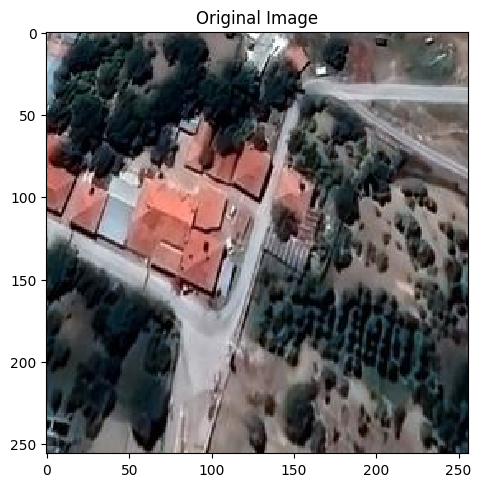

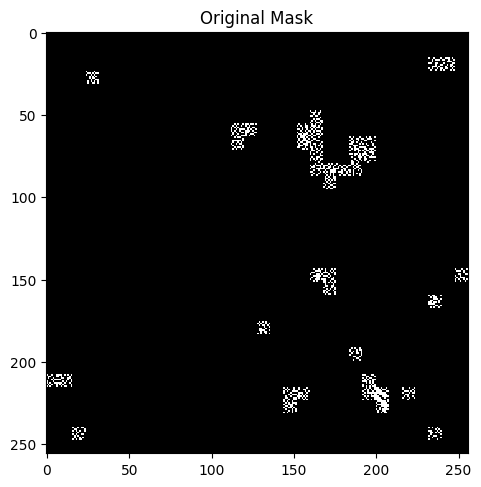

/usr/local/lib/python3.10/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


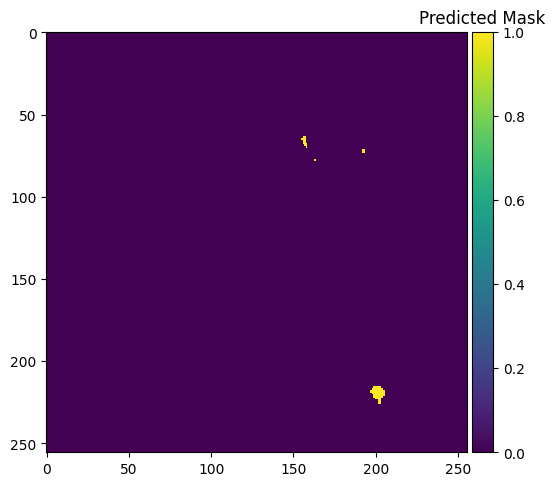

In [4]:
import tensorflow as tf
import os
import numpy as np
from sklearn.model_selection import train_test_split

from tqdm import tqdm
from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt

seed = 42
np.random.seed = seed
import tensorflow as tf
import os
import numpy as np
from sklearn.model_selection import train_test_split

from tqdm import tqdm
from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt

seed = 42
np.random.seed = seed

IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3

ROOT_PATH = '/content/drive/MyDrive/Sowmik Dataset/'

# List of subfolder names containing images
image_subfolders = ['Planned_way/Residence all processed data/Preprocessed Residence',
                    'Planned_way/Residence all processed data/PP aug_residence',
                    'New dataset/Residence_all_processed_data',
                    'New dataset/Aug_all_processed_data/pp_aug_residence']

# List of corresponding subfolders containing masks
mask_subfolders = ['Planned_way/Residence all processed data/Preprocessed Residence/bmask_residence',
                   'Planned_way/Residence all processed data/PP aug_residence/abmask_residence',
                   'New dataset/Residence_all_processed_data/bmask_residence',
                   'New dataset/Aug_all_processed_data/pp_aug_residence/abmask_residence'
                   ]

X_data = []
Y_data = []

for image_subfolder, mask_subfolder in zip(image_subfolders, mask_subfolders):
    IMAGE_PATH = os.path.join(ROOT_PATH, image_subfolder)
    MASK_PATH = os.path.join(ROOT_PATH, mask_subfolder)

    # Get a list of image file names from the current image subfolder
    image_files = [file for file in os.listdir(IMAGE_PATH) if file.endswith('.jpg')]  # Update the file extension if needed

    for n, image_file in tqdm(enumerate(image_files), total=len(image_files)):
        img = imread(os.path.join(IMAGE_PATH, image_file))[:, :, :IMG_CHANNELS]
        img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
        X_data.append(img)

        mask_file = f'pp_{image_file[:-4]}_mask.jpg'
        mask = imread(os.path.join(MASK_PATH, mask_file))
        mask = np.expand_dims(resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True), axis=-1)
        Y_data.append(mask)

X_data = np.array(X_data, dtype=np.uint8)
Y_data = np.array(Y_data, dtype=np.bool)

print('X_data shape:', X_data.shape)
print('Y_data shape:', Y_data.shape)
# Split the data into training and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(X_data, Y_data, test_size=0.1, random_state=seed)
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

#Contraction path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)

c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#Expansive path
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
#model.summary()
# Model checkpoint callback
checkpointer = tf.keras.callbacks.ModelCheckpoint('model_for_green_area.h5', verbose=1, save_best_only=True)
callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
        tf.keras.callbacks.TensorBoard(log_dir='logs')]
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=25, callbacks=callbacks)
# Import necessary libraries
from sklearn.metrics import accuracy_score, f1_score

# Assuming you have loaded and preprocessed your data and trained your model
# ...

# Predict on the validation data
prediction = model.predict(X_val)

# Threshold the predicted probabilities to get binary masks
prediction_binary = (prediction > 0.5).astype(np.uint8)
Y_val_binary = (Y_val > 0.5).astype(np.uint8)

# Calculate accuracy
accuracy = accuracy_score(Y_val_binary.flatten(), prediction_binary.flatten())

# Print the accuracy
print(f"Test Accuracy: {accuracy*100}%")

f1score = f1_score(Y_val_binary.flatten(), prediction_binary.flatten())

# Print the F1-score
print(f"F1-Score: {f1score}")

from sklearn.metrics import precision_score

# Calculate precision
precision = precision_score(Y_val_binary.flatten(), prediction_binary.flatten())

print(f"Precision: {precision}")
# Predict on the validation set
preds_val = model.predict(X_val, verbose=1)

# Threshold predictions (convert to binary)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

# Perform a sanity check on some random validation samples
ix = np.random.randint(0, len(X_val))
imshow(X_val[ix])
plt.title("Original Image")
plt.show()
imshow(np.squeeze(Y_val[ix]))
plt.title("Original Mask")
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.title("Predicted Mask")
plt.show()